In [1]:
#импортируем все необходимые библиотеки для дальнейшего анализа
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import datetime

In [2]:
#выгружаем данные из первой таблицы и смотрим на типы данных 
events = pd.read_csv('/Users/annaruposova/Desktop/Analytics/воронка проект /7_4_Events.csv', sep=',')

Преобразовываем данные:

In [3]:
#удаляем дубликаты (если они есть)
events.drop_duplicates()
#приобразуем столбец в формат datetime для корректных расчетов  
events['start_time'] = pd.to_datetime(events['start_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
#создаем маску для фильтрации данных (нам нужны данные только о тех пользователях, 
#кто зарегестрировался в 2018 году)
mask =(events['start_time']>='2018-01-01') & \
    (events['start_time']<'2019-01-01') & (events['event_type']=='registration')
#создаем список id пользователей, которые зарегестрировались в 2018 году
registered=events[mask].user_id.to_list() 
#создаем итоговый датафрейм с преобразованными и отфильтрованными данными 
events_df=events[events.user_id.isin(registered)]

## Итоговая первая таблица `EVENTS`

In [4]:
events_df.head()

,id,event_type,selected_level,start_time,tutorial_id,user_id
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836


Переходим ко второй таблице ***Purchase***:

In [5]:
purchases = pd.read_csv('/Users/annaruposova/Desktop/Analytics/воронка проект /purchase.csv', sep=',')

Преобразуем стобец ***event_datetime*** в формат datetime аналогично таблице Events:

In [6]:
purchases['event_datetime'] = pd.to_datetime(purchases['event_datetime'], \
                                             format='%Y-%m-%d %H:%M:%S', errors='coerce' )
purchases_df = purchases[purchases['user_id'].isin(registered)]
#добавим к таблице столбец с событием покупки для дальнейшего объединения таблиц
pd.options.mode.chained_assignment = None
purchases_df.loc[:,'event_type'] = 'purchase'

## Итоговая вторая таблица `PURCHASES`

In [7]:
purchases_df.head()

,id,user_id,event_datetime,amount,event_type
1171,16845,27845,2018-01-03 18:53:43,100,purchase
1172,16846,27865,2018-01-04 14:46:10,250,purchase
1174,16848,27911,2018-01-07 08:19:12,50,purchase
1175,16849,27910,2018-01-07 12:11:34,100,purchase
1176,16850,27940,2018-01-07 13:16:41,200,purchase


# РЕШЕНИЕ ЗАДАЧИ №1 
---
>### Нам нужно проверить, отличается ли время прохождения различных этапов для пользователей, которые прошли обучение, от пользователей, не начинавших обучение. 
---
## Алгоритм действий: ##
   
* В задаче есть упоминание о пользователях, которые **не начинали** обучение и пользователи, которые **прошли** обучение. У нас остается еще одна группа: пользователи, которые начали обучение, **но** не прошли его. Я решила оставить эту группу без внимания, т.к. о ней не упоминалось в задаче. И она несет мало смысла, потому что не известно, решил ли пользователь заканчивать обучение или же не намерен этого делать.
   
* И так как задача поставлена не четко, я хочу проанализировать разницу во времени между регистрацией и оплатой, регистрацией и выбором пакета, регистрацией и выбором уровня для двух групп. **Разница во времени** этих этапов и будет **ответом** на вопрос: "отличается ли время прохождения различных этапов для пользователей, которые прошли обучение и не начинали?" соответственно.
   
   

Для начала объединим получившиеся датафреймы в единую таблицу:

In [8]:
#переименовываем столбцы для корректного объединения:
events_df = events_df.rename(columns={"id": "event_id"})
purchases_df = purchases_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})

In [9]:
#объединяем таблицы events_df и purchases_df
total_events_df = pd.concat([events_df,purchases_df],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

## Итоговый датафрейм `total_events_df`

In [10]:
total_events_df.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


*У нас есть единый датафрейм со всеми событиями, включая оплату. Нам нужно разбить пользователей по группам: **прошли обучение/не начинали проходить обучение.** Начнем с первой группы, а именно с сортировки пользователей, которые прошли обучение. У таких пользователей есть событие завершения обучения:*

In [11]:
#создаем список пользователей у которых есть событие tutorial_finish
tutorial_finish = set(total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'])

In [12]:
#создаем датафрейм с нужной нам группой пользователей применияя фильтрацию 
tutorial_finish_df = total_events_df[total_events_df['user_id'].isin(tutorial_finish)]

## Датафрейм с первой группой  `"tutorial_finish_df"`
---
Пользователи, кто прошел обучение. 

In [13]:
tutorial_finish_df.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN


Создаем датасет с событем ***`регистрации для 1-й группы:`***

In [14]:
tutorial_finish_registration = tutorial_finish_df[tutorial_finish_df['event_type'] == 'registration']

In [15]:
#переиминовываем столбы с временем события для дальнешего объединения таблиц
tutorial_finish_registration = tutorial_finish_registration[["user_id", "start_time"]].rename(
    columns={"start_time": "registration_time"})

Создаем датасет с событем  ***`выбор уровня сложности для 1-й группы`***:

In [16]:
#аналогично предыдущим этапам создаем датасет 
tutorial_finish_level_choice = tutorial_finish_df[tutorial_finish_df['event_type'] == 'level_choice'].\
reset_index(drop=True)

In [17]:
tutorial_finish_level_choice = tutorial_finish_level_choice[["user_id", "start_time"]].rename(
    columns={"start_time": "level_choice_time"})

Переходим к объединению датафреймов событий ***регистрации и выбора уровня сложности*** для 1-й группы: 

In [18]:
#объединяем таблицы при помощи функции .merge()
merged_1 = tutorial_finish_registration.merge(tutorial_finish_level_choice, on = 'user_id', how = 'inner')
merged_1.head()

,user_id,registration_time,level_choice_time
0,27835,2018-01-01 11:54:47,2018-01-01 20:37:22
1,27839,2018-01-01 18:24:01,2018-01-01 22:37:50
2,27842,2018-01-01 23:18:46,2018-01-02 08:46:03
3,27843,2018-01-02 00:02:28,2018-01-02 14:09:58
4,27845,2018-01-02 01:35:56,2018-01-02 06:19:18


Рассчитываем ***разницу во времени между событиями выбора уровня сложности и регистрацией:***

In [19]:
#создаем столбец с разницей между временем выбора уровня и временем регистрации:
merged_1['timedelta'] = (merged_1['level_choice_time'] - merged_1['registration_time'])
print('Cреднее время между регистрацией и выбором уровня сложности для 1-й группы составляет:\n',\
      merged_1['timedelta'].mean())
print('Общая информация о временных промежутках между событиями группы, \
закончившей обучение:\n',merged_1['timedelta'].describe())

Cреднее время между регистрацией и выбором уровня сложности для 1-й группы составляет:
 0 days 07:05:36.854819357
Общая информация о временных промежутках между событиями группы, закончившей обучение:
 count                         7501
mean     0 days 07:05:36.854819357
std      0 days 04:30:23.231509186
min                0 days 00:08:15
25%                0 days 03:51:41
50%                0 days 06:00:07
75%                0 days 09:25:42
max                1 days 18:48:25
Name: timedelta, dtype: object


Как видим из описания медианное время отличается от среднего всего на 1ч 5мин.  
25% пользователей, закончившие обучение, прошли путь от регистрации до выбора уровня сложности за 3ч 51мин. 

Создаем датасет с событем  ***`выбор пакетов вопросов для 1-й группы`***:

In [20]:
tutorial_finish_pack_choice = tutorial_finish_df[tutorial_finish_df['event_type'] == 'pack_choice'].\
    reset_index(drop=True)
tutorial_finish_pack_choice = tutorial_finish_pack_choice[["user_id", "start_time"]].rename(
    columns={"start_time": "pack_choice_time"})

Переходим к объединению датафреймов событий ***регистрации и выбора пакетов вопросов*** для 1-й группы: 

In [21]:
merged_2 = tutorial_finish_registration.merge\
(tutorial_finish_pack_choice, on = 'user_id', how = 'inner')
merged_2.head()

,user_id,registration_time,pack_choice_time
0,27835,2018-01-01 11:54:47,2018-01-01 20:38:43
1,27839,2018-01-01 18:24:01,2018-01-01 22:42:54
2,27843,2018-01-02 00:02:28,2018-01-02 14:14:51
3,27845,2018-01-02 01:35:56,2018-01-02 06:25:12
4,27846,2018-01-02 05:07:52,2018-01-02 15:14:18


In [22]:
merged_2['timedelta']  = (merged_2['pack_choice_time'] - merged_2['registration_time'])
print('Cреднее время между регистрацией и выбором пакетов вопросов для 1-й группы составляет:\n',\
      merged_2['timedelta'].mean())

Cреднее время между регистрацией и выбором пакетов вопросов для 1-й группы составляет:
 0 days 07:10:35.660162287


Создаем датасет с событем  ***`покупки для 1-й группы`***:

In [23]:
tutorial_finish_purchase = tutorial_finish_df[tutorial_finish_df['event_type'] == 'purchase'].\
    reset_index(drop=True)
tutorial_finish_purchase = tutorial_finish_purchase[["user_id", "start_time"]].rename(
    columns={"start_time": "purchase_time"})

Переходим к объединению датафреймов событий ***регистрации и покупки*** для 1-й группы: 

In [24]:
merged_3 = tutorial_finish_registration.merge\
(tutorial_finish_purchase, on = 'user_id', how = 'inner')
merged_3.head()

,user_id,registration_time,purchase_time
0,27845,2018-01-02 01:35:56,2018-01-03 18:53:43
1,27884,2018-01-04 11:50:43,2018-01-08 19:37:34
2,27910,2018-01-05 10:45:33,2018-01-07 12:11:34
3,27940,2018-01-05 23:41:24,2018-01-07 13:16:41
4,27969,2018-01-06 19:37:25,2018-01-08 01:18:23


In [25]:
merged_3['timedelta'] = (merged_3['purchase_time'] - merged_3['registration_time'])
print('Cреднее время между регистрацией и покупкой для 1-й группы составляет:\n',merged_3['timedelta'].mean())
print('Общая информация о временных промежутках между событиями группы, \
закончившей обучение:\n',merged_3['timedelta'].describe())
print('Разница между средним и медианным значением времени между событиями:\n',\
      merged_3['timedelta'].mean() - merged_3['timedelta'].median())

Cреднее время между регистрацией и покупкой для 1-й группы составляет:
 4 days 00:30:03.247408431
Общая информация о временных промежутках между событиями группы, закончившей обучение:
 count                         1447
mean     4 days 00:30:03.247408431
std      2 days 04:47:29.946150698
min                0 days 04:36:58
25%                2 days 04:09:55
50%                3 days 19:04:59
75%                5 days 15:46:14
max               11 days 00:35:04
Name: timedelta, dtype: object
Разница между средним и медианным значением времени между событиями:
 0 days 05:25:04.247408431


Как видим, медианное время отличается от среднего значения на 5ч. 25минут.  
Это может быть обусловлено тем, что некоторые пользователи проходят этапы намного дольше, тем самым увеличивают среднее значение. 
>Как к примеру мы видим, что максимальное время, которое пользователь затратил между этапами регристрации и покупкой это 11 дней 35минут, что более чем в 2раза больше среднего знаечения.

Переходим к ***созданию 2-й группы:*** 

In [26]:
#создаем множество со всеми пользователями 
set_registered_users=set(total_events_df.user_id)
#множество с пользователями, которые начали обучение
set_with_start_tutorial = set(total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id'])
#множество с пользователями, не начинавшими обучение
not_started_tutorial = set_registered_users.difference(set_with_start_tutorial)
#итоговый датасет со 2-й группой
not_started_tutorial_df = total_events_df[total_events_df['user_id'].isin(not_started_tutorial)]

## Датафрейм со второй группой  `"not_started_tutorial_df"`
---
Пользователи, кто не начинал обучение

In [27]:
not_started_tutorial_df.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN
27,80335.0,registration,NaN,2018-01-02 00:13:22,NaN,27844,NaN,NaN
37,80345.0,registration,NaN,2018-01-02 06:05:02,NaN,27848,NaN,NaN


Создаем датасет с событем ***`регистрации для 2-й группы:`***

In [28]:
not_started_tutorial_registration = not_started_tutorial_df[not_started_tutorial_df['event_type'] == 'registration'].\
    reset_index(drop=True)
not_started_tutorial_registration = not_started_tutorial_registration[["user_id", "start_time"]].rename(
    columns={"start_time": "registration_time"})

Создаем датасет с событем  ***`выбор пакетов вопросов для 2-й группы`***:

In [29]:
not_started_tutorial_level_choice = not_started_tutorial_df[not_started_tutorial_df['event_type'] == 'level_choice'].\
    reset_index(drop=True)
not_started_tutorial_level_choice = not_started_tutorial_level_choice[["user_id", "start_time"]].rename(
    columns={"start_time": "level_choice_time"})

Переходим к объединению датафреймов событий ***регистрации и выбора уровня сложности*** для 2-й группы: 

In [30]:
merged_n1 = not_started_tutorial_registration.merge(not_started_tutorial_level_choice,\
                                                    on = 'user_id', how = 'inner')
merged_n1.head()

,user_id,registration_time,level_choice_time
0,27921,2018-01-05 16:13:17,2018-01-06 01:58:40
1,28033,2018-01-08 16:52:19,2018-01-08 17:06:39
2,28145,2018-01-10 18:12:47,2018-01-11 00:04:20
3,28464,2018-01-17 04:34:00,2018-01-17 06:46:05
4,28865,2018-01-23 12:48:01,2018-01-23 14:21:24


In [31]:
merged_n1['timedelta'] = (merged_n1['level_choice_time'] - merged_n1['registration_time'])
print('Cреднее время между регистрацией и выбором уровня сложности для 2-й группы составляет:\n',
      merged_n1['timedelta'].mean())

Cреднее время между регистрацией и выбором уровня сложности для 2-й группы составляет:
 0 days 05:15:33.122448979


Создаем датасет с событем  ***`выбор пакетов вопросов для 2-й группы`***:

In [32]:
not_started_tutorial_pack_choice = not_started_tutorial_df[not_started_tutorial_df['event_type'] == 'pack_choice'].\
    reset_index(drop=True)
not_started_tutorial_pack_choice = not_started_tutorial_pack_choice[["user_id", "start_time"]].rename(
    columns={"start_time": "pack_choice_time"})

Переходим к объединению датафреймов событий ***регистрации и выбора пакетов вопросов*** для 2-й группы: 

In [33]:
merged_n2 = not_started_tutorial_registration.merge(not_started_tutorial_pack_choice,\
                                                    on = 'user_id', how = 'inner')
merged_n2.head()

,user_id,registration_time,pack_choice_time
0,28033,2018-01-08 16:52:19,2018-01-08 17:11:52
1,28145,2018-01-10 18:12:47,2018-01-11 00:12:15
2,28865,2018-01-23 12:48:01,2018-01-23 14:28:33
3,28928,2018-01-24 04:55:27,2018-01-24 14:06:56
4,29066,2018-01-26 07:20:10,2018-01-26 08:40:14


In [34]:
merged_n2['timedelta'] = (merged_n2['pack_choice_time'] - merged_n2['registration_time'])
print('Cреднее время между регистрацией и выбором пакетов вопросов для 2-й группы составляет:\n',\
      merged_n2['timedelta'].mean())

Cреднее время между регистрацией и выбором пакетов вопросов для 2-й группы составляет:
 0 days 05:07:16.175675675


Создаем датасет с событем  ***`покупки для 2-й группы`***:

In [35]:
not_started_tutorial_purchase = not_started_tutorial_df[not_started_tutorial_df['event_type'] == 'purchase']
not_started_tutorial_purchase = not_started_tutorial_purchase[["user_id", "start_time"]].rename(
    columns={"start_time": "purchase_time"})

In [36]:
merged_n3 = not_started_tutorial_registration.merge(not_started_tutorial_purchase,\
                                                    on = 'user_id', how = 'inner')
merged_n3.head()

,user_id,registration_time,purchase_time
0,28033,2018-01-08 16:52:19,2018-01-16 05:08:41
1,28928,2018-01-24 04:55:27,2018-01-29 14:47:12
2,31161,2018-03-04 21:30:50,2018-03-09 14:10:27
3,32975,2018-03-26 20:17:00,2018-04-01 08:53:29
4,33253,2018-03-30 13:48:43,2018-04-06 03:49:04


In [37]:
merged_n3['timedelta'] = (merged_n3['purchase_time'] - merged_n3['registration_time'])
print('Cреднее время между регистрацией и оплатой для 2-й группы составляет:\n',merged_n3['timedelta'].mean())

Cреднее время между регистрацией и оплатой для 2-й группы составляет:
 4 days 09:06:01.909090909


*И наконец подсчитаем **разницу** между средним временем прохождения всех этапов 1 и 2 групп.*

In [38]:
dif_registration_level_choice = (merged_1['timedelta'].mean())-(merged_n1['timedelta'].mean())
print('Разница среднего времени от момента регистрации до выбора уровня сложности\nмежду двумя группами равна:\n',\
      dif_registration_level_choice)

Разница среднего времени от момента регистрации до выбора уровня сложности
между двумя группами равна:
 0 days 01:50:03.732370378


In [39]:
dif_registration_pack_choice = (merged_2['timedelta'].mean())-(merged_n2['timedelta'].mean())
print('Разница среднего времени от события регистрации до выбора уровня пакетов вопросов\
\nмежду двумя группами равна:\n',
dif_registration_pack_choice)

Разница среднего времени от события регистрации до выбора уровня пакетов вопросов
между двумя группами равна:
 0 days 02:03:19.484486612


In [40]:
dif_registration_purchase = (merged_n3['timedelta'].mean()) - (merged_3['timedelta'].mean())
print('Разница среднего времени от события регистрации до покупки\
\nмежду двумя группами равна:\n',
dif_registration_purchase)

Разница среднего времени от события регистрации до покупки
между двумя группами равна:
 0 days 08:35:58.661682478


Для удобства меняем значения user_id на отметки:  
* __`'yes'`__- пользователи, кто прошел обучение   
* __`'no'`__ - пользователи, кто не начинал обучение 

<Axes: title={'center': 'Время прохождения различных этапов для двух групп'}, xlabel='user_id'>

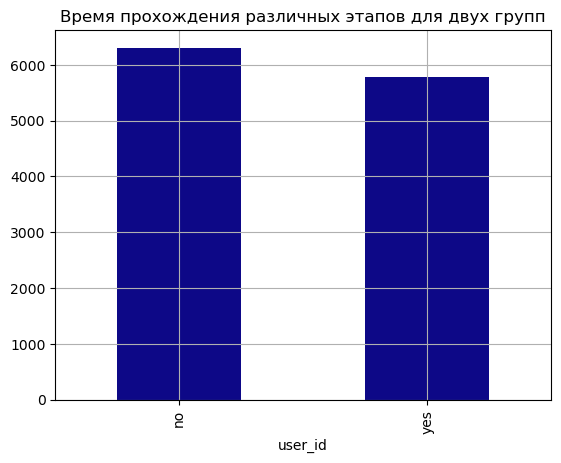

In [41]:
#для удобства переиминуем строки с id 
merged_3['user_id']='yes'
merged_n3['user_id']='no'
#объединяем датасеты для выведения в график
total=pd.concat([merged_3,merged_n3], sort=False) 
#переводим данные со временем в минуты для корректной визуализации
total['timedelta']=total['timedelta']/pd.Timedelta('1 minute') 
total.groupby(by = ['user_id'])['timedelta'].mean().plot(kind = 'bar', 
                                                    grid= True, 
                                                    colormap = 'plasma', 
                                                    title = 'Время прохождения различных этапов для двух групп') 

# ВЫВОДЫ ДЛЯ ЗАДАЧИ №1 #


>Таблица со показателями среднего значения прохождения различных этапов для 1-й и 2-й групп* соответственно: 
---
*Напомню, что под 1-ой группой подразумеваются пользователи, закончившие обучение. Под 2-ой группой пользователи, не начинавшие обучение

---
|      | Первая группа               | Вторая группа | Разница |
| :------------- |:------------------:|:------------------:|:------------------:|
|Среднее время от этапа ***регистрации до выбора уровня сложности*** | 07ч. 05мин. | 05ч. 15мин.  | 1ч. 50мин. |
|Среднее время от этапа ***регистрации до выбора пакетов вопросов***| 07ч. 10мин. | 05ч. 07мин. | 2ч. 03мин.|
|Среднее время от этапа ***регистрации до оплаты***| 4дня 30мин.| 4дня 09ч. 06мин.| 8ч. 36мин.|

> ***Целью*** данного анализа было выявить насколько обучение сокращает время прохождения всех этапов. И ответить на вопрос «Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение?» 
---

 Мы видим, что в первых двух случаях, а именно с момента регистрации до выбора уровня сложности и выбора пакетов вопросов, пользователи из первой группы затратили больше времени, чем пользователи из второй группы. 
 Возможно это связано с прохождением этапов обучения, но для окончательного ответа потребуется дополнительный анализ. 
 
 А вот в случае со временем с момента регистрации до покупки, первая группа показала большую заинтересованность, тк справилась с этим этапом быстрее второй группы на 8часов 36минут. 
 Так же хочу отметить медианное значение для первой группы. У 50% пользователей с момента регистрации до оплаты проходит 3дня 19часов 5 минут. Это на 5часов 25минут меньше среднего показателя этого же параметра.   
 И если сравнить медианное значение двух групп, то получается, что 50% пользователей, кто прошел обучение с момента регистрации доходят до этапа оплаты на 16ч. 24мин. быстрее, чем 50% пользователей из группы, кто не начинал обучение. 
 
 Таким образом можно сказать, что да, **время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение отличается.**  
 Событие обучения ускоряет процесс покупки платных пакетов вопросов и **благополучно влияет на выбор пользователя в сторону оплаты.** Можно предположить, что этап обучения делает клиента увернее в своих возможностях, тем самым **подталкивает**  приобрести дополнительные пакеты с вопросами.
 
 
 А факт того, что пользователь **не начинал обучение наоборот оттягивает** время покупки по сравнению с теми, кто начинал обучение. 

# РЕШЕНИЕ ЗАДАЧИ №2 
---
### Необходимо посмотреть, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь и доказать, что успешное обучение само по себе влияет на оплату, и без разницы, каким этапом оно шло.
---
## Алгоритм действий: ##
   
 #### Делим пользователей на 6 групп: ####

1. Пользователи, которые начали, но не закончили обучение.
2. Пользователи, которые закончили обучение только 1 раз.
3. Пользователи, которые закончили обучение 2-3 раза.
4. Пользователи, которые закончили обучение 4-5 раз.
5. Пользователи, которые закончили обучение 6-7 раз.
6. Пользователи, которые закончили обучение 8-9 раз.

#### Считаем процент пользователей, кто совершил покупку для каждой группы. 

#### Смотрим разницу между группами. 

Воспользуемся нашим датафреймом, где мы собрали все события: 

In [42]:
total_events_df.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


*Для начала посмотрим еще раз на количество **всех пользователей** (не зависимо прошли они обучение или нет) в нашем датафрейме.*

In [43]:
#берем из общего датасета уникальное количество пользователей
total_users=total_events_df['user_id'].nunique()  
total_users

19926

*Приступим к формированию **1 группы**. Нам нужны пользователи, **которые начали обучение, но не прошли его** ни разу, т.е. пользователи у которых есть событие начала обучения, но нет события окончания обучения.* 

In [44]:
#создаем список с пользователями, которые закончили обучение
finished_tutorial = total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'].unique() 
#создаем множество с пользователями, которые начали обучение
users_with_start=set(total_events_df[total_events_df.event_type=='tutorial_start']['user_id'])
#убираем из сета с пользователей, завершивших обучение, и оставляем только тех, 
#кто стартовал, но не закончил 
grouped_1 = users_with_start.difference(set(finished_tutorial))

*__Формируем датафреймы__ с группами пользователей, которые прошли обучение:* 

In [45]:
#из общего датафрейма убираем ненужные нам столбцы и оставляем только пользователей и тип событий
total=total_events_df.drop(total_events_df.columns[[0,2,3,4,6,7]],axis=1) 
#фильтруем датафрейм и оставлям только пользователей с событием окончания обучения
total_finish_users=total[(total['event_type']=='tutorial_finish')].reset_index(drop=True)

*Давайте посмотрим какое **максимальное** количество раз пользователь прошел обучение в нашей игре для того что бы в дальнейшем **корректно** разбить всех на группы:
Заодно для удобства я **переиминую столбец** с событиями, ведь теперь там будет содержаться информация о **количестве** пройденных обучений одним пользователем.*

In [46]:
#переиминовываем столбец с событием
grouped_df =total_finish_users.rename(columns={'event_type':'count_tutorial'})
#группируем столбец по пользователю
grouped_df=grouped_df.groupby(['user_id'], as_index=False).count()
grouped_df.count_tutorial.max()

9

*Итак, мы узнали, что **максимальное** количество полных обучений на пользователя равно **9**.*

*Я решила разделить всех пользователей на **6 групп**. Об этом я писала выше в **АЛГОРИТМЕ действий**.*

*Приступим к **формированию** оставшихся групп:* 

In [47]:
#выставляем фильтр на нужное количество обучений и записываем получившихся пользователей во множество

#формируем 2-ю группу:
grouped_2=set(grouped_df[grouped_df['count_tutorial']==1]['user_id'])

#формируем 3-ю группу:
grouped_3=set(grouped_df[(grouped_df['count_tutorial']==2)|(grouped_df['count_tutorial']==3)]['user_id'])

#формируем 4-ю группу:
grouped_4=set(grouped_df[(grouped_df['count_tutorial']==4)|(grouped_df['count_tutorial']==5)]['user_id'])

#формируем 5-ю группу:
grouped_5=set(grouped_df[(grouped_df['count_tutorial']==6)|(grouped_df['count_tutorial']==7)]['user_id'])

#формируем 6-ю группу:
grouped_6=set(grouped_df[(grouped_df['count_tutorial']==8)|(grouped_df['count_tutorial']==9)]['user_id'])

### Настало время подсчитать процент пользователей в каждой группе, совершившей покупки.

In [48]:
#подсчет для 1-й группы
#считаем число пользователей, которые оплатили пакет вопросов, в 1-й группе
count_1 = len(purchases_df[purchases_df['user_id'].isin(grouped_1)]['user_id'].unique())
#делим число оплативших пользователей на число всех пользователей данной группы, что бы узнать процент оплативших
percent_1 = (count_1/len(grouped_1))
print('Общее количество пользователей в 1-й группе:\n',len(grouped_1))
print('Число пользователей, которые оплатили тренировки (от числа пользователей 1-й группы):\n',count_1)
print ('Процент пользователей, которые оплатили тренировки (от числа пользователей 1-й группы):\n {:.2%}'.\
       format(percent_1))

Общее количество пользователей в 1-й группе:
 1608
Число пользователей, которые оплатили тренировки (от числа пользователей 1-й группы):
 131
Процент пользователей, которые оплатили тренировки (от числа пользователей 1-й группы):
 8.15%


*Проделываем все тоже самое с **другими группами**:*

In [49]:
#подсчет для 2-й группы
count_2 = len(purchases_df[purchases_df['user_id'].isin(grouped_2)]['user_id'].unique())
percent_2 = (count_2/len(grouped_2))
print('Общее количество пользователей в 2-й группе:\n',len(grouped_2))
print('Число пользователей, которые оплатили тренировки (от числа пользователей 2-й группы):\n',count_2)
print ('Процент пользователей, которые оплатили тренировки (от числа пользователей 2-й группы):\n {:.2%}'.\
       format(percent_2))

Общее количество пользователей в 2-й группе:
 8015
Число пользователей, которые оплатили тренировки (от числа пользователей 2-й группы):
 1143
Процент пользователей, которые оплатили тренировки (от числа пользователей 2-й группы):
 14.26%


In [50]:
#подсчет для 3-й группы
count_3 = len(purchases_df[purchases_df['user_id'].isin(grouped_3)]['user_id'].unique())
percent_3 = (count_3/len(grouped_3))
print('Общее количество пользователей в 3-й группе:\n',len(grouped_3))
print('Число пользователей, которые оплатили тренировки (от числа пользователей 3-й группы):\n',count_3)
print ('Процент пользователей, которые оплатили тренировки (от числа пользователей 3-й группы):\n{:.2%}'.\
       format(percent_3))

Общее количество пользователей в 3-й группе:
 1666
Число пользователей, которые оплатили тренировки (от числа пользователей 3-й группы):
 226
Процент пользователей, которые оплатили тренировки (от числа пользователей 3-й группы):
13.57%


In [51]:
#подсчет для 4-й группы
count_4 = len(purchases_df[purchases_df['user_id'].isin(grouped_4)]['user_id'].unique())
percent_4 = (count_4/len(grouped_4))
print('Общее количество пользователей в 4-й группе:\n',len(grouped_4))
print('Число пользователей, которые оплатили тренировки (от числа пользователей 4-й группы):\n',count_4)
print ('Процент пользователей, которые оплатили тренировки (от числа пользователей 4-й группы):\n {:.2%}'.\
       format(percent_4))

Общее количество пользователей в 4-й группе:
 295
Число пользователей, которые оплатили тренировки (от числа пользователей 4-й группы):
 38
Процент пользователей, которые оплатили тренировки (от числа пользователей 4-й группы):
 12.88%


In [52]:
#подсчет для 5-й группы
count_5 = len(purchases_df[purchases_df['user_id'].isin(grouped_5)]['user_id'].unique())
percent_5 = (count_5/len(grouped_5))
print('Общее количество пользователей в 5-й группе:\n',len(grouped_5))
print('Число пользователей, которые оплатили тренировки (от числа пользователей 5-й группы):\n',count_5)
print ('Процент пользователей, которые оплатили тренировки (от числа пользователей 5-й группы):\n {:.2%}'.\
       format(percent_5))

Общее количество пользователей в 5-й группе:
 198
Число пользователей, которые оплатили тренировки (от числа пользователей 5-й группы):
 30
Процент пользователей, которые оплатили тренировки (от числа пользователей 5-й группы):
 15.15%


In [53]:
#подсчет для 6-й группы
count_6 = len(purchases_df[purchases_df['user_id'].isin(grouped_6)]['user_id'].unique())
percent_6 = (count_6/len(grouped_6))
print('Общее количество пользователей в 6-й группе:\n',len(grouped_6))
print('Число пользователей, которые оплатили тренировки (от числа пользователей 6-й группы):\n',count_6)
print ('Процент пользователей, которые оплатили тренировки (от числа пользователей 6-й группы):\n {:.2%}'.\
       format(percent_6))

Общее количество пользователей в 6-й группе:
 76
Число пользователей, которые оплатили тренировки (от числа пользователей 6-й группы):
 10
Процент пользователей, которые оплатили тренировки (от числа пользователей 6-й группы):
 13.16%


### Строим диаграмму для визуализации полученных результатов: 

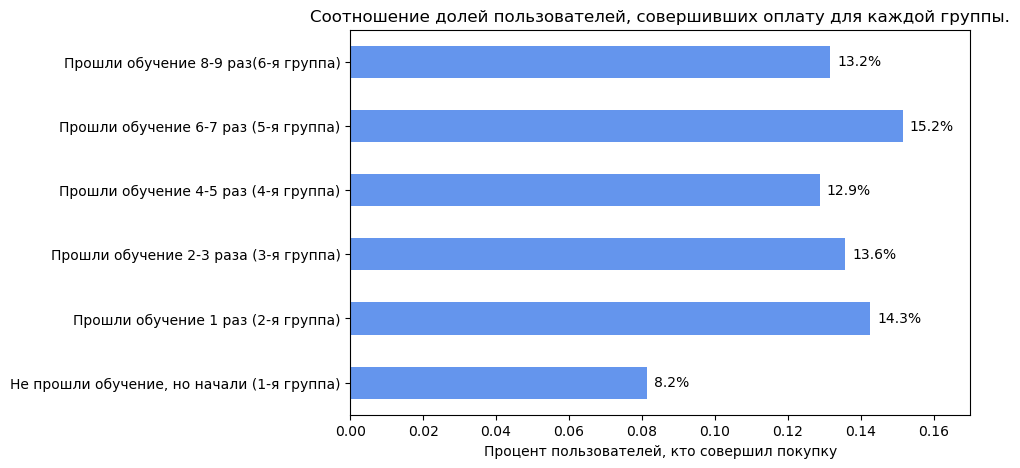

In [54]:
frequencies = [0.0815, 0.1426, 0.1357, 0.1288, 0.1515, 0.1316]

freq_series = pd.Series(frequencies)

y_labels = ['Не прошли обучение, но начали (1-я группа)',
            'Прошли обучение 1 раз (2-я группа)',
            'Прошли обучение 2-3 раза (3-я группа)', 
            'Прошли обучение 4-5 раз (4-я группа)', 
            'Прошли обучение 6-7 раз (5-я группа)', 
            'Прошли обучение 8-9 раз(6-я группа)']
plt.figure(figsize=(8, 5)) 
ax = freq_series.plot(kind='barh', color='cornflowerblue')
ax.set_title('Соотношение долей пользователей, совершивших оплату для каждой группы.')
ax.set_xlabel('Процент пользователей, кто совершил покупку')
ax.set_yticklabels(y_labels)
ax.set_xlim(0, 0.17) 
rects = ax.patches

for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    space = 5
    ha = 'left'

    label = "{:.1%}".format(x_value)

    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(space, 0),          
        textcoords="offset points", 
        va='center',                
        ha=ha)      

# ВЫВОДЫ ДЛЯ ЗАДАЧИ №2 #

> **Целью** данного анализа было доказать, что успешное обучение само по себе влияет на оплату. И ответить на вопрос «Существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь?»

На графике нагладно представлено, на сколько группа пользователей, кто не прошел обучение, отстает в показателе. 
Из первой группы на 6.1 процентных пункта меньше участников заинтересованы в покупке покетов вопросов в сравнении с 2-й группой, кто прошел обучение 1 раз.  
А вот если посмотреть на все группы с событиями обучения (5 групп) то видно, что процент варьируется от 13% до 15%.
Из этого можно сделать вывод, что само по себе успешное обученение **положительно влияет на оплату и не важно какое количество раз пользователь проходил его.**  
Зависимости между вероятностью оплаты и количеством обучений **не наблюдается.** 

# РЕШЕНИЕ ЗАДАЧИ №3 
---
### Нам нужно выяснить как часто пользователи начинают обучение после того, как они выбрали уровень сложности.
---
## Алгоритм действий: ##
* Я решила выбрать только тех пользователей, кто содержит события начала обучения и выбора уровня сложности. 
* Далее я хочу выделить из этой выборки пользователей, кто повторно обратился к обучению после выбора уровня. 
* Таким образом я найду процент пользователей, кто вернулся к обучению, от общего количества пользователей, выбравших уровень сложности.

In [55]:
#выводим итоговую таблицу со всеми событиями, с ней мы будем работать в дальнейшем
total_events_df.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN


Переходим к созданию датасета с событием **обучения**:

In [56]:
#создаем датасет с пользователями, кто содержит событие начала обучения 
users_with_start=set(total_events_df[total_events_df['event_type'] == 'tutorial_start']['user_id']) 
#создаем общий датасет с пользователями, кто содержит событие начала обучения
users_with_start_df = total_events_df[total_events_df['user_id'].isin(users_with_start)]
#создаем датасет, который содержит только события начала обучения
tutorial_start_df = users_with_start_df[users_with_start_df['event_type'] == 'tutorial_start'].\
    sort_values( by = 'start_time').reset_index(drop=True)
#оставляем нужные колонки и переименовываем их для дальнейшего обединения в единый датасет со следующим событием
tutorial_start_df = tutorial_start_df[['user_id', 'start_time']].\
    rename(columns = {'start_time':'tutorial_start_time'})
tutorial_start_df.head()

,user_id,tutorial_start_time
0,27836,2018-01-01 14:54:40
1,27835,2018-01-01 15:00:51
2,27836,2018-01-01 15:40:43
3,27833,2018-01-01 17:47:40
4,27839,2018-01-01 19:11:36


Далее создаем датасет с событием **выбора уровня:**  

In [57]:
#берем данные из общего датасета с пользователями, кто содержит событие начала обучения
#отбираем только события выбора уровня
level_choice_df = users_with_start_df[users_with_start_df['event_type'] == 'level_choice'].\
    sort_values( by = 'start_time')
level_choice_df = level_choice_df[['user_id', 'start_time']].\
    rename(columns = {'start_time':'level_choice_time'}).reset_index(drop=True)
level_choice_df = level_choice_df.sort_values(
    "level_choice_time")
level_choice_df.head()

,user_id,level_choice_time
0,27835,2018-01-01 20:37:22
1,27839,2018-01-01 22:37:50
2,27840,2018-01-02 05:18:42
3,27845,2018-01-02 06:19:18
4,27842,2018-01-02 08:46:03


Объединяем получившиеся датасеты для дальнейшего формирования групп:

In [58]:
#объединяем данные при помощи функции .merge()
merged_group = tutorial_start_df.merge(level_choice_df, on = 'user_id', how = 'inner')
#создаем новый столбец, где будет храниться информация о разнице во времени прохождения этапов 
merged_group['timedelta'] = merged_group['tutorial_start_time'] - merged_group['level_choice_time']
merged_group

,user_id,tutorial_start_time,level_choice_time,timedelta
0,27835,2018-01-01 15:00:51,2018-01-01 20:37:22,-1 days +18:23:29
1,27839,2018-01-01 19:11:36,2018-01-01 22:37:50,-1 days +20:33:46
2,27840,2018-01-02 02:07:07,2018-01-02 05:18:42,-1 days +20:48:25
3,27845,2018-01-02 03:03:44,2018-01-02 06:19:18,-1 days +20:44:26
4,27845,2018-01-02 07:08:00,2018-01-02 06:19:18,0 days 00:48:42
...,...,...,...,...
12681,47732,2018-12-31 07:14:38,2018-12-31 09:59:00,-1 days +21:15:38
12682,47747,2018-12-31 10:21:11,2018-12-31 12:24:40,-1 days +21:56:31
12683,47753,2018-12-31 20:54:56,2018-12-31 22:36:19,-1 days +22:18:37
12684,47755,2019-01-01 00:08:14,2019-01-01 05:04:52,-1 days +19:03:22


Мы получили данные о **разнице во времени** между прохождением этапа начала обучения и выбора уровня. 
если результат получился с положительным значением, значит пользователь возвращался к обучению после выбора уровня. Обозначим пользователей, кто обращался к обучению в этом же датасете. 
> Отметим значением ***'yes'*** пользователей, кто обращался к обучению снова и ***'no'*** оставшихся пользователей. 

In [59]:
#определяем переменную с которой будем сравнивать наше время 
delta = datetime.timedelta(days = 0, hours = 0, minutes = 0, seconds = 0)
#создаем функцию, которая будет распределять пользователей по группам
def assignment(time): 
    if time>delta:
        return 'yes' 
    else: 
        return 'no'
#создаем новый столбец, куда запишем метки распределения по группам 
merged_group['groups'] = merged_group.timedelta.apply(assignment) 
merged_group.head()

,user_id,tutorial_start_time,level_choice_time,timedelta,groups
0,27835,2018-01-01 15:00:51,2018-01-01 20:37:22,-1 days +18:23:29,no
1,27839,2018-01-01 19:11:36,2018-01-01 22:37:50,-1 days +20:33:46,no
2,27840,2018-01-02 02:07:07,2018-01-02 05:18:42,-1 days +20:48:25,no
3,27845,2018-01-02 03:03:44,2018-01-02 06:19:18,-1 days +20:44:26,no
4,27845,2018-01-02 07:08:00,2018-01-02 06:19:18,0 days 00:48:42,yes


Итак, мы получили информацию о пользователях, кто обратился снова к обучению, после выбора уровня.  
Посмотрим на **количество пользователей и определим его процент от общего количества пользователей**, выбравших уровень сложности:

In [60]:
count_return = merged_group[merged_group['groups'] == 'yes'].user_id.nunique()
print('Количество пользователей, кто вернулся после выбора сложности к обучению:\n', count_return)

Количество пользователей, кто вернулся после выбора сложности к обучению:
 1386


In [61]:
total_count = merged_group['user_id'].nunique()
print('Общее количество пользователей, кто выбрал уровень сложности:\n', total_count)

Общее количество пользователей, кто выбрал уровень сложности:
 8244


И наконец, найдем процент пользователей, кто обратился снова к обучению, от общего количества:

In [62]:
percent_of_total = count_return/total_count
print('Процент пользователей, кто обратился снова к обучению, от общего количества составляет:\n{:.2%}'.\
      format(percent_of_total))

Процент пользователей, кто обратился снова к обучению, от общего количества составляет:
16.81%


## Ниже представлена диаграмма, отражающая процент пользователей, которые после выбора уровня сложности обращаются к обучению, от общего числа пользователей содержащих событие выбора уровня.  ##

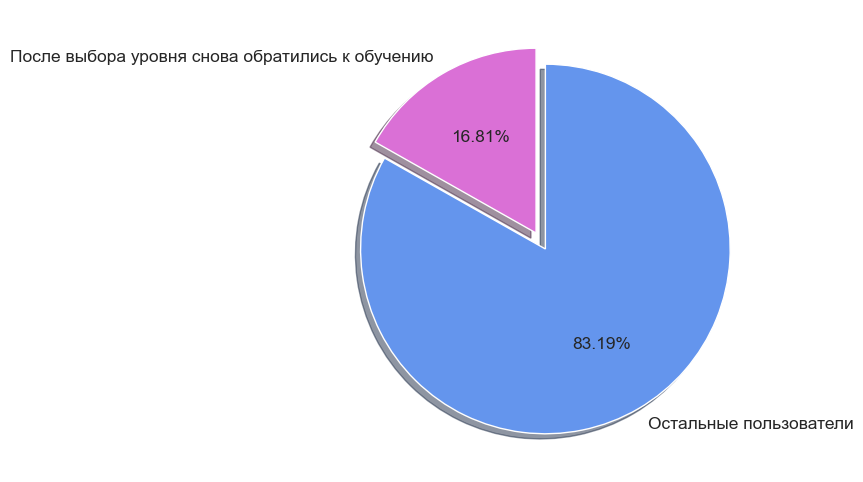

In [63]:
sns.set(font_scale = 1.2)
plt.figure(figsize=(6,6))
plt.pie(
    x=[1386, 6858], 
    labels=['После выбора уровня снова обратились к обучению', 'Остальные пользователи'],
    autopct='%1.2f%%',
    textprops={'fontsize':12.5},
    shadow = True,
    startangle = 90,
    colors=['orchid', 'cornflowerblue'],
    explode=[0.05, 0.05]
)
plt.show()

# ВЫВОДЫ ДЛЯ ЗАДАЧИ №3: #
> **Целью** задачи было понять, насколько прозрачен процесс взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна. 
---

Если посмотреть на **процентное соотношения пользователей**, тех кто после выбора уровня сложности обратились к обучению снова, и остальных пользователей, у кого есть событие выбора уровня сложности (**16.8%** против **83.2%** соответственно) можно сказать, что **процент пользователей**, кто снова обращался к обучению не такой большой. И можно считать процесс взаимодействия с игрой прозрачным. Однако для точного ответа хотелось бы рассмотреть отдельно пользовательские пути участников игры, кто возращается к обучению, и временные промежутки между событиями. Тк вполне возможно, что часть из них обращалась за обучением дабы освежить знания а не потому что процесс не понятнен. 

На основании проведенного мною **анализа**, могу сказать, что **процесс взаимодействия с игрой достаточно прозрачен**.